<a id='begin'></a>
# Tensorflow basics

This notebook provides the example of building Logistic Regression classification model for the syntetic data. There is a description for each step of the code, but I strongly suggest to read these materials [[**1**](https://www.tensorflow.org/get_started/basic_usage), [2](https://www.tensorflow.org/how_tos/variables/), [**3**](http://camron.xyz/index.php/2016/08/22/in_a_nutshell_part_one/)] for better understanding of TF concept, how the computations are actually done and what's going on in the code.

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# Data generation

Here we sample 2D data frow two different multivariate Gaussian distributions (500 points from each):
* $\mathcal{N}\left( \mu_1, \Sigma_1 \right),\text{ where } \mu_1 = \begin{bmatrix} 2\\5 \end{bmatrix},\,\, \Sigma_1 = \begin{bmatrix} 1 & 0\\0 & 2 \end{bmatrix}$
* $\mathcal{N}\left( \mu_2, \Sigma_2 \right),\text{ where } \mu_2 = \begin{bmatrix} 6\\3 \end{bmatrix},\,\, \Sigma_1 = \begin{bmatrix} 2 & 0\\0 & 1 \end{bmatrix}$

and assign them with two different classes: $-1$ and $1$.

In [4]:
mu1, sigma1 = [2, 5], np.diag([1, 2])
mu2, sigma2 = [6, 3], np.diag([2, 1])

In [5]:
data1 = np.random.multivariate_normal(mu1, sigma1, 500)
ans1 = np.ones(data1.shape[0], dtype=np.int32)
data2 = np.random.multivariate_normal(mu2, sigma2, 500)
ans2 = -np.ones(data2.shape[0], dtype=np.int32)

In [6]:
data = np.append(data1, data2, axis=0)
data = np.array(data, dtype=np.float32)
ans = np.reshape(np.append(ans1, ans2, axis=0), (ans1.shape[0] + ans2.shape[0], 1))

Splitting data into train and test in the fraction of $\frac{4}{1}$

In [7]:
data_train, data_test, ans_train, ans_test = train_test_split(data, ans, test_size=0.2)

Visualization

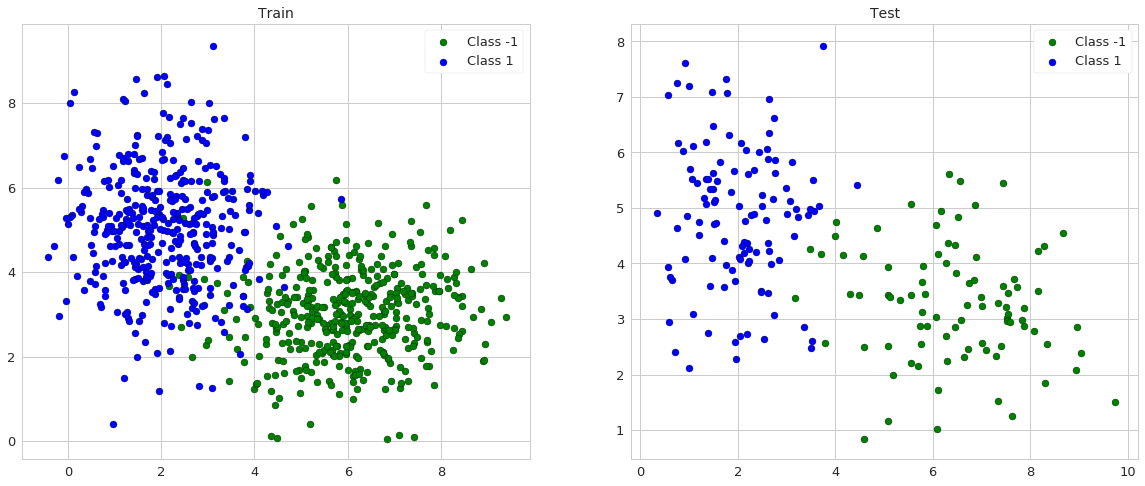

In [8]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.scatter(data_train[(ans_train == -1).ravel()].T[0], 
            data_train[(ans_train == -1).ravel()].T[1], 
            color="g", edgecolors="k", 
            label="Class -1")
plt.scatter(data_train[(ans_train == 1).ravel()].T[0], 
            data_train[(ans_train == 1).ravel()].T[1], 
            color="b", edgecolors="k", 
            label="Class 1")
plt.legend()
plt.title("Train", fontsize=14)

plt.subplot(122)
plt.scatter(data_test[(ans_test == -1).ravel()].T[0], 
            data_test[(ans_test == -1).ravel()].T[1], 
            color="g", edgecolors="k", 
            label="Class -1")
plt.scatter(data_test[(ans_test == 1).ravel()].T[0], 
            data_test[(ans_test == 1).ravel()].T[1], 
            color="b", edgecolors="k", 
            label="Class 1")
plt.legend()
plt.title("Test", fontsize=14);

# Simplest TF model

Placeholders provide interface for feeding data into the model. For now it is some kind of a template for future data that should be fed into the model on the training stage.

Here we create two placeholders:
* **x** is for features with the shape of $\text{data size } \times \text{ dimension of data}$; data size can be put to $\text{None}$, then the size will be determined during training
* **y** is for class labels

In [9]:
x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.float32, [None, 1])

The next step is to create variables which store weights and biases of our logistic regression model and which will be optimized during training.

As far as we have 2D task (only 2 features per object) and we need to predict only one value (probability of belonging to class $1$), the dimension of the weight matrix if $2 \times 1$ and bias is just a number.

In [10]:
W = tf.Variable(tf.random_uniform([2, 1], minval=0.0, maxval=4.0), name="Weights")
b = tf.Variable(tf.zeros([1]), name="Bias")

Just the copy of the initial value of weights and biases. It is needed here just for the sake of comparison of the of the initial random guess and optimized result.

In [11]:
W_initial = tf.Variable(W.initialized_value())
b_initial = tf.Variable(b.initialized_value())

Our actual model. We do the prediction simply by multiplying feature representation of the object by the weight matrix and adding bias.

$$
y = \text{Sign}\left(\text{W}\cdot\mathbf{x} + b\right)\\
$$

Notice that we store data such that objects are in rows. Thus in the formula below $\mathbf{x}$ and $\text{W}$ change places.

In [12]:
pred = tf.matmul(x, W) + b

Here is the place to determine objective function. For the logistic regression it is the following:

$$
\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n} \log \left\lbrace 1 + \exp [-y_i \cdot \text{pred}_i] \right\rbrace = \frac{1}{n}\sum_{i=1}^{n} \log \left\lbrace 1 + \exp [-y_i \cdot \text{Sign} \left( \text{W} \cdot \mathbf{x}_i + b \right)] \right\rbrace
$$

We also use regularization for model not to overfit. For logistic regression it usually leads to 1-2% improvement. The final objective is

$$
\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n} \log \left\lbrace 1 + \exp [-y_i \cdot \text{Sign} \left( \text{W} \cdot \mathbf{x}_i + b \right)] \right\rbrace + \lambda \left( \|\text{W}\|_2 + \|\text{b}\|_2 \right)
$$

In [13]:
loss = tf.reduce_mean(tf.log(1 + tf.exp(- y * pred)) + 
                      0.001 * (tf.nn.l2_loss(W) + tf.nn.l2_loss(b)))

Also we want to compute accuracy of the classification.

$$
\text{Accuracy} = \frac{\#[y = \text{pred}]}{n}
$$

In [14]:
acc = tf.reduce_mean(tf.to_float(tf.equal(tf.sign(pred), y)))

Now we have model and objective done.

Next step is to train it all. For this purpose we use simple Gradient Descent algorithm with learning rate equal to $0.5$

In [15]:
learning_rate = 0.5
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

Up to this point we created only templates for the computations and variables. Now we need to initialize them and to build a computational graph.

In [16]:
init = tf.global_variables_initializer()

Create TF session in which we're going to do all the stuff and run initialization process

In [17]:
sess = tf.Session()
sess.run(init)

Let's take a look at the loss and accuracy before training the model

To do so we need to run desired function defined above and supply it with the value for the placeholders created before

In [18]:
print("Initial loss = ", sess.run(loss, {x: data_train, y: ans_train}))
print("Initial accuracy = ", sess.run(acc, {x: data_train, y: ans_train}))

Initial loss =  5.0242
Initial accuracy =  0.485


The accuracy is about 0.5 which corresponds to the random guessing in case of balanced classes.

Now let's train the model. Here I choose to do it for 25 epochs (or 25 steps of gradient descent algorithm in our case).

One can play both with the learning rate and the number of epochs to find the happy medium.

In [19]:
training_epochs = 25
loss_hist = []
acc_hist = []
for i in range(training_epochs):
    _, l, a =  sess.run([optimizer, loss, acc], feed_dict={x: data_train, y: ans_train})
    loss_hist.append(l)
    acc_hist.append(a)

Let's see how training was going

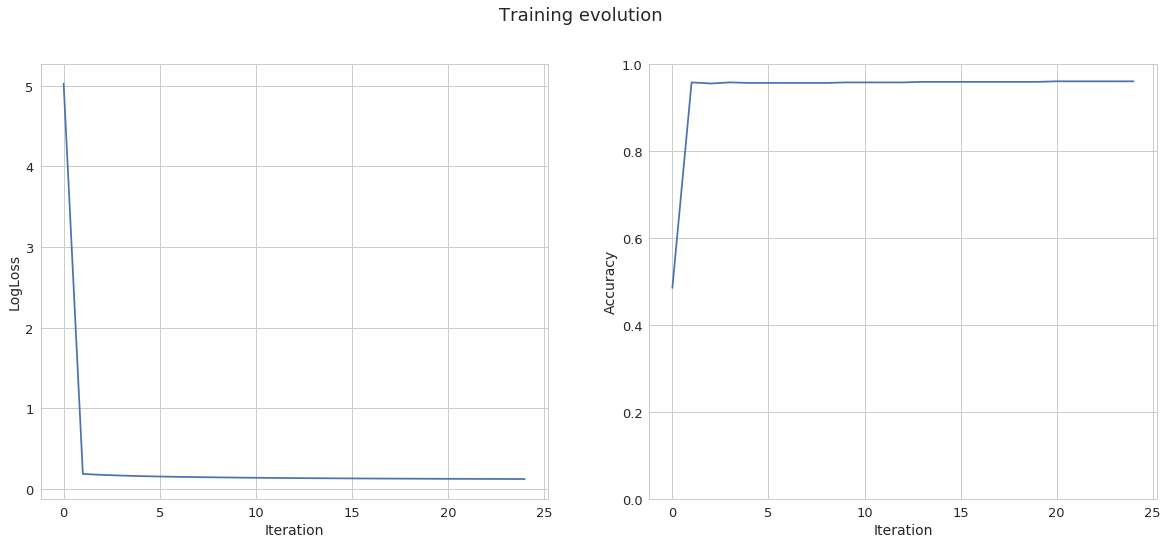

In [20]:
plt.figure(figsize=(20, 8))
plt.suptitle("Training evolution", fontsize=18)

plt.subplot(121)
plt.plot(loss_hist)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("LogLoss", fontsize=14)

plt.subplot(122)
plt.plot(acc_hist)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim([0., 1.0]);

In [21]:
print("Final loss = ", sess.run(loss, {x: data_train, y: ans_train}))
print("Final accuracy = ", sess.run(acc, {x: data_train, y: ans_train}))

Final loss =  0.122467
Final accuracy =  0.96


Now let's visualize the separating hyperplanes (SH)

In [22]:
W_value = sess.run(W)
b_value = sess.run(b)
W_initial_value = sess.run(W_initial)
b_initial_value = sess.run(b_initial)

In [23]:
acc_train = sess.run(acc, {x: data_train, y: ans_train})
acc_test = sess.run(acc, {x: data_test, y: ans_test})

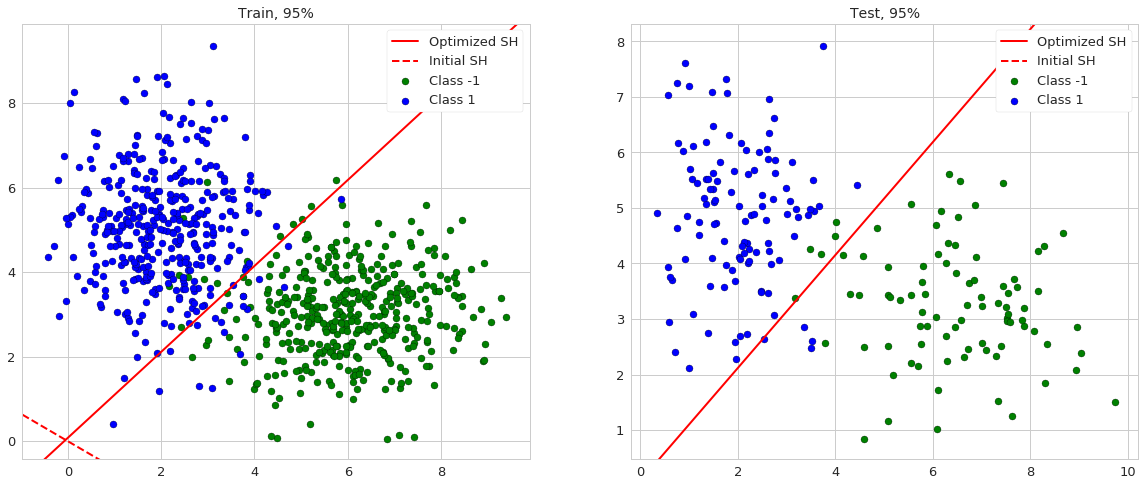

In [24]:
plt.figure(figsize=(20, 8))

# Train
plt.subplot(121)
plt.scatter(data_train[(ans_train == -1).ravel()].T[0], 
            data_train[(ans_train == -1).ravel()].T[1], 
            color="g", edgecolors="k", 
            label="Class -1")
plt.scatter(data_train[(ans_train == 1).ravel()].T[0], 
            data_train[(ans_train == 1).ravel()].T[1], 
            color="b", edgecolors="k", 
            label="Class 1")
axes = plt.gca()
xlim = axes.get_xlim()
ylim = axes.get_ylim()
plt.plot([xlim[0], xlim[1]], np.array([-W_value[0][0]*xlim[0] - b_value[0],
                                       -W_value[0][0]*xlim[1] - b_value[0]]) / W_value[1][0], \
         "r", linewidth=2, label="Optimized SH")
plt.plot([xlim[0], xlim[1]], np.array([-W_initial_value[0][0]*xlim[0] - b_initial_value[0],
                                       -W_initial_value[0][0]*xlim[1] - b_initial_value[0]]) / W_value[1][0], 
         "r--", linewidth=2, label="Initial SH")
axes.set_xlim(xlim)
axes.set_ylim(ylim)
plt.legend()
plt.title("Train, " + str(int(100 * acc_train)) + "%", fontsize=14)

# Test
plt.subplot(122)
plt.scatter(data_test[(ans_test == -1).ravel()].T[0], 
            data_test[(ans_test == -1).ravel()].T[1], 
            color="g", edgecolors="k", 
            label="Class -1")
plt.scatter(data_test[(ans_test == 1).ravel()].T[0], 
            data_test[(ans_test == 1).ravel()].T[1], 
            color="b", edgecolors="k", 
            label="Class 1")
axes = plt.gca()
xlim = axes.get_xlim()
ylim = axes.get_ylim()
plt.plot([xlim[0], xlim[1]], np.array([-W_value[0][0]*xlim[0] - b_value[0],
                                       -W_value[0][0]*xlim[1] - b_value[0]]) / W_value[1][0], \
         "r", linewidth=2, label="Optimized SH")
plt.plot([xlim[0], xlim[1]], np.array([-W_initial_value[0][0]*xlim[0] - b_initial_value[0],
                                       -W_initial_value[0][0]*xlim[1] - b_initial_value[0]]) / W_value[1][0], 
         "r--", linewidth=2, label="Initial SH")
axes.set_xlim(xlim)
axes.set_ylim(ylim)
plt.legend()
plt.title("Test, " + str(int(100 * acc_test)) + "%", fontsize=14);

# Tensorboard

Very usefull part of the tensorflow framework is **tensorboard** [[4](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/), [5](https://www.tensorflow.org/how_tos/graph_viz/)] which allows to visualize different metrics, model structure and learning process automatically. For simple models like Logistic Regression it can be not so crucial but for more complicated models like Neural Nets with numerous stacked layers these graphs and flows become extremely useful.

In [25]:
learning_rate = 0.1
training_epochs = 25
display_step = 5
logs_path = './logs'

Beforehand we create all the nodes in the so called "default" graph which was created automatically. Now we want to create a new model. 

First way is to generate a new Graph via $\text{tf.Graph}$ and then create all the operators and variables inside it using python construction $\text{with g.as_default():}$.

Here we choose another way and just flushed the default graph.

In [26]:
tf.reset_default_graph()

Doing the same stuff as before, but now we assign the name to each variable and function (actually nodes in the computational graph)

In [27]:
x = tf.placeholder(tf.float32, [None, 2], name="InputData")
y = tf.placeholder(tf.float32, [None, 1], name="LabelData")

In [28]:
W = tf.Variable(tf.random_uniform([2, 1], minval=0.0, maxval=4.0), name="Weights")
b = tf.Variable(tf.zeros([1]), name="Bias")

Here we introduce so called *name scopes* which allow to divide computational graph into logical parts thus it is easy to observe and debug inside tensorboard.

In [29]:
with tf.name_scope('Model'):
    pred = tf.matmul(x, W) + b
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.log(1 + tf.exp(- y * pred)) + 
                          0.001 * (tf.nn.l2_loss(W) + 
                                   tf.nn.l2_loss(b)))
with tf.name_scope("Optimization"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
with tf.name_scope('Accuracy'):
    acc = tf.equal(tf.sign(pred), y)
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

Initialize graph

In [30]:
init = tf.global_variables_initializer()

Then it's time to create *tracers* for different nodes in graph, which are responsible for collecting an information about a node during the training process.

In particular here we want to see the error and accuracy evolution over the training epochs. Previously we did it just by creating two arrays $\text{loss_hist}$ and $\text{acc_hist}$ and append values to them manually at each step.

Now we're just going to create *summary* instances which will do it automatically.

In [31]:
# create a summary to monitor loss tensor
tf.summary.scalar("loss", loss)
# create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc)
# merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

Create TF session in which we're going to do all the stuff and run initialization process

In [32]:
sess = tf.Session()
sess.run(init)

Now it's time to create operator that will write summary logs.

In [33]:
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

Training phase

In [34]:
for epoch in range(training_epochs):
    _, summary = sess.run([optimizer, merged_summary_op], 
                          feed_dict={x: data_train, y: ans_train})
    summary_writer.add_summary(summary, epoch)

It is important to close the $\text{SummaryWriter}$ class otherwise we won't be able to work with created report in Tensorboard while the kernel is alive.

In [35]:
summary_writer.close()

After that one should be able to run Tensorboard with the following command from the terminal:

    $ tensorboard --logdir=logs
    
and access it via browser at the address:
    
    localhost:6006
    
In my case the contents of the page is following:

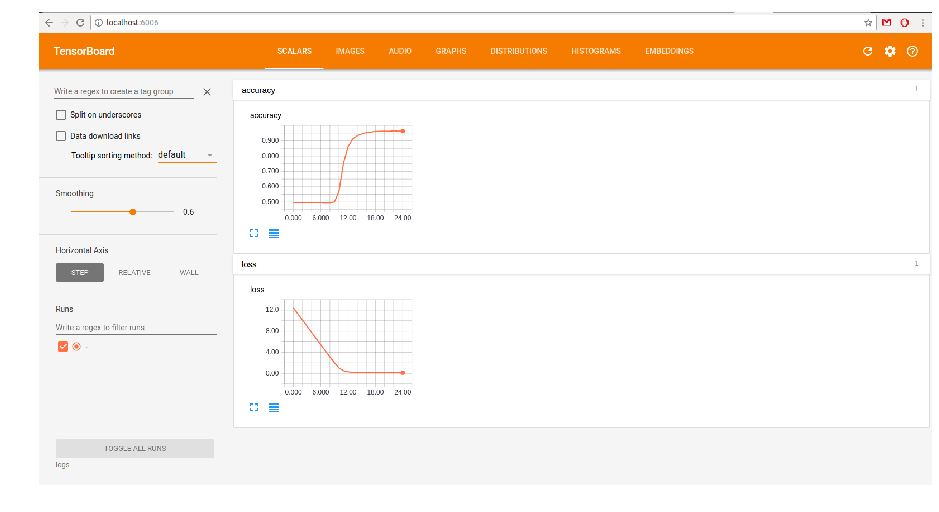

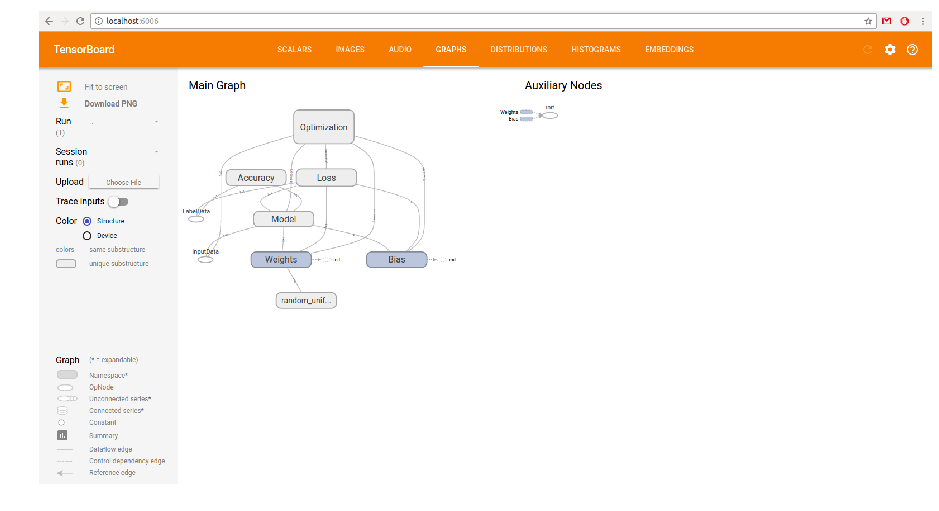

In [36]:
pic = plt.imread('tensorboard1.png')
plt.figure(figsize=(16,12))
plt.imshow(pic)
plt.axis('off')
plt.show()
pic = plt.imread('tensorboard2.png')
plt.figure(figsize=(16,12))
plt.imshow(pic)
plt.axis('off')
plt.show()